# Clasificación de textos con Transformer

**Autor:** Gonzalo Martínez Fernández  
**Creación:** 2024/03/31  
**Descripción:** Este documento busca implementar un Transformer a través de la librería Keras para clasificar textos.

## Configuración (Setup)

En primer lugar, se debe instalar y actualizar Keras en caso de que no se haya hecho previamente. Asimismo, se importan las librerías y módulos necesarios.

In [ ]:
!pip install keras --upgrade

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 25.8 MB/s eta 0:00:0000:0100:01
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.0/312.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 5.8 MB/s eta 0:00:00


In [1]:
import keras
import pandas as pd
from keras import ops
from keras import layers

2024-04-17 17:47:47.959891: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 17:47:48.212026: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 17:47:49.081417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 17:47:51.871660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Preparación del dataset

[El dataset](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset)

In [2]:
import numpy as np
from tensorflow import string as tf_string
from tensorflow import Tensor

def random_split(x_data,y_data,test_rate):
    '''
    ### Parameters
        - num_elements -> int: length of the dataset.
        - test_rate -> float: percentage of test data.

    ### Return
        - (train data,test data)
    '''
    if isinstance(x_data,Tensor):
        x_data = x_data.numpy()
    assert x_data.shape[0] == y_data.shape[0], "Data must have the same length"
    indices = np.arange(x_data.shape[0])
    np.random.shuffle(indices)
    test_index = int(test_rate * x_data.shape[0]) + 1
    return (x_data[indices[test_index:]],
            y_data.iloc[indices[test_index:]].values,
            x_data[indices[:test_index]],
            y_data.iloc[indices[:test_index]].values)

def split_label(data,label):
    column_list = list(data.columns)
    column_list.remove(label)
    return data[column_list].reset_index(),data[label].reset_index()

def label_to_classes(data,label):
    labels = {class_:i for i,class_ in enumerate(data[label].unique())}
    data[label] = data[label].map(labels)
    return data

def create_vectorizator(data,maxlen):
    vectorizator = keras.layers.TextVectorization(
        output_mode='int',
        output_sequence_length=maxlen
    )
    vectorizator.adapt(list(data['Document']))
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(1,),dtype=tf_string))
    model.add(vectorizator)
    return model

vocab_size = 25000
maxlen = 32

raw_data = pd.read_csv('data/all_tickets_processed_improved_v3.csv')#[:vocab_size]
labelled_data = label_to_classes(raw_data,'Topic_group')
vectorizator = create_vectorizator(raw_data,maxlen)
x_data = vectorizator(labelled_data['Document'])
y_data = labelled_data['Topic_group']
x_train,y_train,x_val,y_val = random_split(x_data,y_data,0.3)


2024-04-17 17:48:05.878137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 17:48:05.880434: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-17 17:48:06.256052: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33368800 exceeds 10% of free system memory.
2024-04-17 17:48:06.256101: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50053200 exceeds 10% 

## Implementación del Transformer como una capa

Se corresponde con el Encoder?

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

## Implementación de una capa de *embedding*

Se realizan dos capas distintas: una para los *tokens* y otra para sus posiciones en el texto.

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [5]:
#vocab_size = 25000  # Only consider the top 20k words
#maxlen = 100  # Only consider the first 200 words of each movie review
#data = pd.read_csv('data/all_tickets_processed_improved_v3.csv')[:vocab_size]
#(x_train, y_train), (x_val, y_val) = keras.datasets.reuters.load_data(num_words=vocab_size)
#print(len(x_train), "Training sequences")
#print(len(x_val), "Validation sequences")
#x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
#x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

In [6]:
x_train[0]

array([ 372,  130,    8,    2, 1150,   11,  513,  495,  415, 2268,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [7]:
y_train[:20]

array([1, 5, 5, 6, 4, 3, 4, 0, 6, 0, 2, 1, 0, 0, 0, 2, 1, 4, 1, 0])

## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.

In [28]:
import os
from math import ceil
import matplotlib.pyplot as plt
DATA_FOLDER = 'data'

class TransformerClassifier():

    def __init__(self,embed_dim,num_heads,ff_dim,maxlen,vocab_size,nneuronas=20,dense_layers=None) -> None:
        inputs = layers.Input(shape=(maxlen,))
        embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        x = embedding_layer(inputs)
        transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        x = transformer_block(x)
        
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dropout(0.1)(x)
        if dense_layers is None:
            x = layers.Dense(nneuronas, activation="relu")(x)
            x = layers.Dropout(0.1)(x)
        else:
            for nneuron in dense_layers:
                x = layers.Dense(nneuron, activation="relu")(x)
                x = layers.Dropout(0.1)(x)
        outputs = layers.Dense(8, activation="softmax")(x)

        self.model = keras.Model(inputs=inputs, outputs=outputs)
        self.history = None

    def fit(self,x_train,y_train,x_val,y_val,batch_size=32,epochs=20,learning_rate=0.0001):
        self.model.compile(
            optimizer= keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.98,epsilon=10**-9), 
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        self.history = self.model.fit(
            x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val)
        )
        return self.history

    def download_history(self,filename,run_name):
        DATA_CSV = f'{DATA_FOLDER}/{filename}.csv'
        assert self.history is not None, "History of the model is None!"
        history = self.history.history
        if not os.path.exists(DATA_FOLDER):
            os.mkdir('data')
        writing_mode = 'w'
        if os.path.exists(DATA_CSV): 
            data = pd.read_csv(DATA_CSV)
            assert run_name not in data['run'].unique(), f"The run_name {run_name} exists already!"
            writing_mode = 'a'
        with open(DATA_CSV,writing_mode,encoding='utf8') as f:
            keys = [key for key in history]
            if writing_mode == 'w':
                f.write('run,epoch,' + ','.join(keys) + '\n')
            epochs = len(list(history.items())[0][1])
            for epoch in range(epochs):
                newline = f'{run_name},{epoch+1},'
                for key in keys:
                    newline += str(history[key][epoch]) + ','
                f.write(newline[:-1] + '\n')

In [22]:
def plot_performance(filename,title):
    COLORS = ['#05a8aa','#b8d5b8','#d7b49e','#dc602e',
            '#090c08','#474056','#757083',
            '#8a95a5','#b9c6ae','#bc412b']
    data = pd.read_csv(f'{DATA_FOLDER}/{filename}.csv')
    keys = data.columns[2:]
    axes = {k:None for k in keys}
    rows = ceil(len(keys)/2)
    plt.suptitle(title)
    for i,key in enumerate(axes):
        axes[key] = plt.subplot(rows,2,i+1)
    for i,batch in enumerate(data['run'].unique()):
        for key in axes:
            axes[key].title.set_text(key.capitalize())
            axes[key].plot(data[data['run']==batch]['epoch'],
                        data[data['run']==batch][key],
                        color=COLORS[i],label=str(batch))

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.plot()

## Experimentos

#### Búsqueda de razón de aprendizaje (*learning_rate*):

Epoch 1/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - accuracy: 0.1712 - loss: 2.0857 - val_accuracy: 0.3275 - val_loss: 1.8446
Epoch 2/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.3157 - loss: 1.8494 - val_accuracy: 0.4055 - val_loss: 1.7226
Epoch 3/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - accuracy: 0.3795 - loss: 1.7341 - val_accuracy: 0.4720 - val_loss: 1.5962
Epoch 4/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 53s 50ms/step - accuracy: 0.4435 - loss: 1.6146 - val_accuracy: 0.5481 - val_loss: 1.4527
Epoch 5/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 56s 54ms/step - accuracy: 0.5132 - loss: 1.4734 - val_accuracy: 0.5957 - val_loss: 1.3057
Epoch 6/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 84s 56ms/step - accuracy: 0.5609 - loss: 1.3326 - val_accuracy: 0.6325 - val_loss: 1.1678
Epoch 7/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 55s 53ms/step - accuracy: 0.6091 - loss: 1.1952 - val_accuracy: 0.6679 - val_loss: 1.0531
Epoch 8/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.6408 -

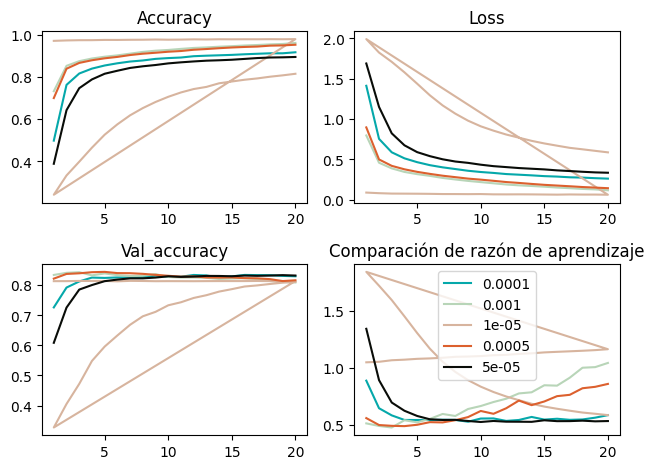

In [38]:
# Values: [0.0001,0.001,0.00001,0.0005,0.00005]
for learning_rate in [0.00001,0.0005,0.00005]:
    transformer = TransformerClassifier(
        embed_dim=32,
        num_heads=8,
        ff_dim=64,
        maxlen=maxlen,
        vocab_size=25000
        )
    transformer.fit(
        x_train,y_train,
        x_val,y_val,
        batch_size=32,
        epochs=20,
        learning_rate=learning_rate
    )
    transformer.download_history('performance_definitive',str(learning_rate))
plot_performance('performance_definitive','Comparación de razón de aprendizaje')

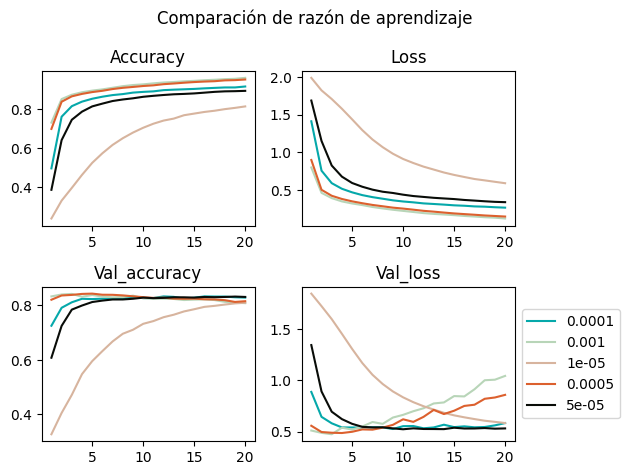

In [23]:
plot_performance('performance_definitive','Comparación de razón de aprendizaje')

#### Búsqueda de mejor longitud de secuencias máxima

El valor de la razón de aprendizaje que mejores resultados ofreció fue 0.0001, pues aunque no alcanzó el rendmiento de entrenamiento de 0.0005 y 0.001, el rendimiento del conjunto de prueba no decrece. Por otro lado, iguala el rendimiento de prueba con la razón 0.00005 pero lo supera en el conjunto de entrenamiento.

Epoch 1/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 46s 38ms/step - accuracy: 0.3933 - loss: 1.6793 - val_accuracy: 0.7287 - val_loss: 0.8547
Epoch 2/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.7368 - loss: 0.8223 - val_accuracy: 0.7846 - val_loss: 0.6620
Epoch 3/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.8016 - loss: 0.6350 - val_accuracy: 0.7972 - val_loss: 0.6177
Epoch 4/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8249 - loss: 0.5557 - val_accuracy: 0.8056 - val_loss: 0.5983
Epoch 5/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8354 - loss: 0.5172 - val_accuracy: 0.8060 - val_loss: 0.5955
Epoch 6/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.8496 - loss: 0.4747 - val_accuracy: 0.8089 - val_loss: 0.5904
Epoch 7/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 68s 29ms/step - accuracy: 0.8506 - loss: 0.4775 - val_accuracy: 0.8079 - val_loss: 0.5905
Epoch 8/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.8587 -

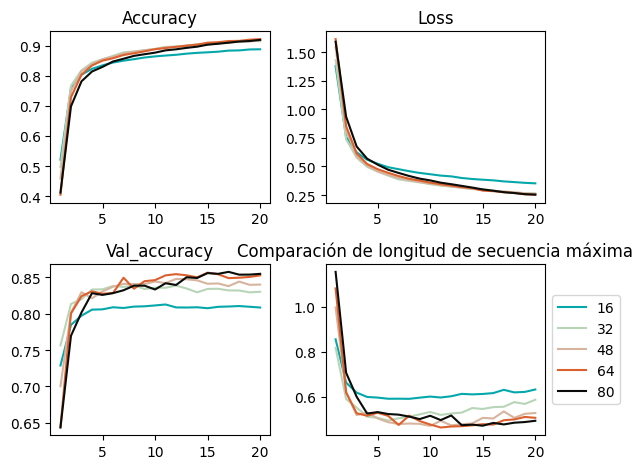

In [8]:
# Values: [16,32,48,64,80]
for maxlenval in [16,32,48,64,80]:
    raw_data = pd.read_csv('data/all_tickets_processed_improved_v3.csv')#[:vocab_size]
    labelled_data = label_to_classes(raw_data,'Topic_group')
    vectorizator = create_vectorizator(raw_data,maxlenval)
    x_data = vectorizator(labelled_data['Document'])
    y_data = labelled_data['Topic_group']
    x_train,y_train,x_val,y_val = random_split(x_data,y_data,0.3)
    transformer = TransformerClassifier(
        embed_dim=32,
        num_heads=8,
        ff_dim=64,
        maxlen=maxlenval,
        vocab_size=25000
        )
    transformer.fit(
        x_train,y_train,
        x_val,y_val,
        batch_size=32,
        epochs=20,
        learning_rate=0.0001
    )
    transformer.download_history('performance_seclength',str(maxlenval))

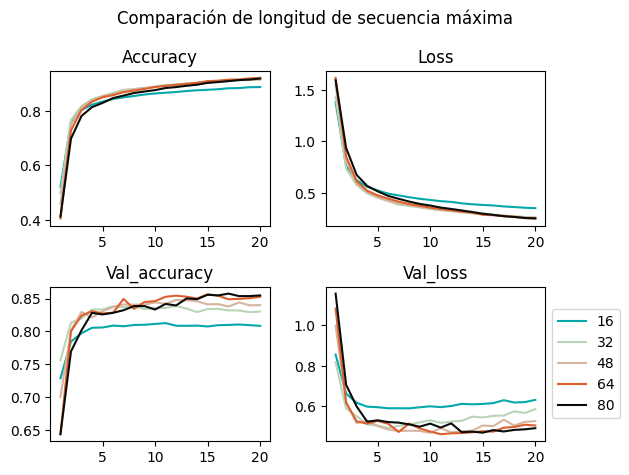

In [24]:
plot_performance('performance_seclength','Comparación de longitud de secuencia máxima')

#### Número de neuronas en la red de clasificación lineal

Se usarán vectores de 64 elementos porque maximizan el rendimiento de entrenamiento y prueba pero son vectores más pequeños que los de 80 elementos, por lo que se procesan más rápido.

In [26]:
# Values: [5,10,20,30,40]

raw_data = pd.read_csv('data/all_tickets_processed_improved_v3.csv')#[:vocab_size]
labelled_data = label_to_classes(raw_data,'Topic_group')
vectorizator = create_vectorizator(raw_data,64)
x_data = vectorizator(labelled_data['Document'])
y_data = labelled_data['Topic_group']
x_train,y_train,x_val,y_val = random_split(x_data,y_data,0.3)

for nneuronas in [5,10,20,30,40]:
    transformer = TransformerClassifier(
        embed_dim=32,
        num_heads=8,
        ff_dim=64,
        maxlen=64,
        vocab_size=25000,
        nneuronas=nneuronas
        )
    transformer.fit(
        x_train,y_train,
        x_val,y_val,
        batch_size=32,
        epochs=20,
        learning_rate=0.0001
    )
    transformer.download_history('performance_neuronas_lineal',str(nneuronas))

Epoch 1/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 107s 96ms/step - accuracy: 0.2892 - loss: 1.9824 - val_accuracy: 0.5386 - val_loss: 1.6563
Epoch 2/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.4971 - loss: 1.5656 - val_accuracy: 0.5616 - val_loss: 1.4033
Epoch 3/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 107s 103ms/step - accuracy: 0.5710 - loss: 1.3756 - val_accuracy: 0.6020 - val_loss: 1.3446
Epoch 4/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - accuracy: 0.6249 - loss: 1.2577 - val_accuracy: 0.6775 - val_loss: 1.1949
Epoch 5/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 91s 84ms/step - accuracy: 0.6850 - loss: 1.1381 - val_accuracy: 0.7210 - val_loss: 1.0802
Epoch 6/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 104s 99ms/step - accuracy: 0.6981 - loss: 1.0503 - val_accuracy: 0.7207 - val_loss: 1.0379
Epoch 7/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 99s 94ms/step - accuracy: 0.7208 - loss: 0.9566 - val_accuracy: 0.7143 - val_loss: 0.9607
Epoch 8/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.7

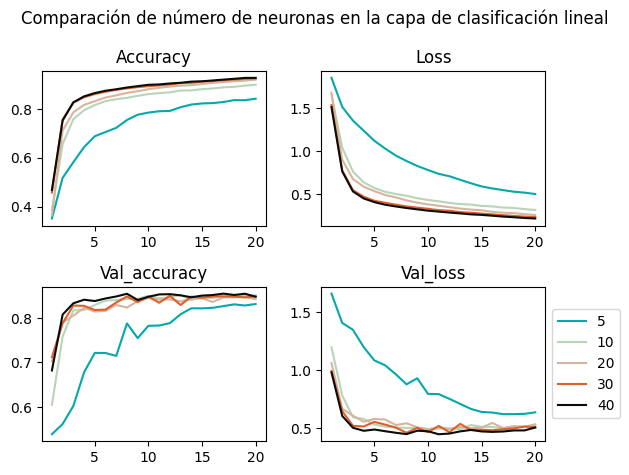

In [27]:
plot_performance('performance_neuronas_lineal','Comparación de número de neuronas en la capa de clasificación lineal')

#### Número de capas de la red de clasificación lineal

In [29]:
# Values: [[30,15],[30,10],[30,30],[30,40],[30,15,7]]

raw_data = pd.read_csv('data/all_tickets_processed_improved_v3.csv')#[:vocab_size]
labelled_data = label_to_classes(raw_data,'Topic_group')
vectorizator = create_vectorizator(raw_data,64)
x_data = vectorizator(labelled_data['Document'])
y_data = labelled_data['Topic_group']
x_train,y_train,x_val,y_val = random_split(x_data,y_data,0.3)

for layer in [[30,15],[30,10],[30,30],[30,40],[30,15,7]]:
    transformer = TransformerClassifier(
        embed_dim=32,
        num_heads=8,
        ff_dim=64,
        maxlen=64,
        vocab_size=25000,
        dense_layers=layer
        )
    transformer.fit(
        x_train,y_train,
        x_val,y_val,
        batch_size=32,
        epochs=20,
        learning_rate=0.0001
    )
    transformer.download_history('performance_capas',f'"str(layer)"')

Epoch 1/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 95s 84ms/step - accuracy: 0.2415 - loss: 1.9271 - val_accuracy: 0.6665 - val_loss: 1.1147
Epoch 2/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 142s 84ms/step - accuracy: 0.6414 - loss: 1.0934 - val_accuracy: 0.7538 - val_loss: 0.7858
Epoch 3/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 79s 75ms/step - accuracy: 0.7257 - loss: 0.8401 - val_accuracy: 0.7656 - val_loss: 0.7408
Epoch 4/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.7620 - loss: 0.7293 - val_accuracy: 0.8073 - val_loss: 0.6152
Epoch 5/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.7928 - loss: 0.6486 - val_accuracy: 0.8069 - val_loss: 0.5906
Epoch 6/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 90s 82ms/step - accuracy: 0.8190 - loss: 0.5793 - val_accuracy: 0.8272 - val_loss: 0.5479
Epoch 7/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 146s 86ms/step - accuracy: 0.8341 - loss: 0.5362 - val_accuracy: 0.8308 - val_loss: 0.5303
Epoch 8/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 90s 86ms/step - accuracy: 0.8457

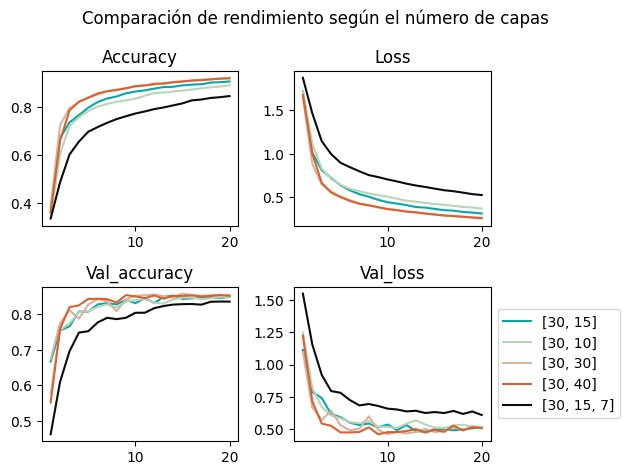

In [31]:
plot_performance('performance_capas','Comparación de rendimiento según el número de capas')